# 🛠️ Phase 4: Feature Engineering - Laboratorio de Experimentos

En esta fase transformamos los datos limpios y la información macroeconómica en características (features) que el modelo pueda procesar. 

**Objetivos:**
1. Crear variables de calendario (Festivos, Fines de semana, Semana Santa).
2. Generar variables cíclicas (Sin/Cos) para mes y trimestre.
3. Implementar 'Flags' estructurales (COVID, Retail).
4. Integrar variables macroeconómicas relevantes.
5. Exportar el dataset final en formato `.parquet` para el modelado.

In [1]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import datetime

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Cargar Configuración
with open('../config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

fe_conf = config['feature_engineering']
paths = config['paths']

print("✅ Configuración cargada correctamente.")

✅ Configuración cargada correctamente.


In [2]:
# 1️⃣ Carga de Entradas
sales_path = os.path.join("..", paths['cleansed_data'], fe_conf['input']['sales_file'])
macro_path = os.path.join("..", paths['features_data'], fe_conf['input']['macro_file'])

df_sales = pd.read_csv(sales_path, parse_dates=['fecha'], index_col='fecha')
df_macro = pd.read_csv(macro_path, parse_dates=['fecha'], index_col='fecha')

df_sales.sort_index(inplace=True)
df_macro.sort_index(inplace=True)

print(f"📈 Ventas cargadas: {df_sales.shape[0]} registros.")
print(f"🌍 Macro cargado: {df_macro.shape[0]} registros.")

📈 Ventas cargadas: 86 registros.
🌍 Macro cargado: 97 registros.


### 2️⃣ Ingeniería de Calendario
Creamos variables que capturan el ritmo de vida en Colombia.

In [3]:
def get_calendar_features(df):
    df = df.copy()
    co_holidays = holidays.Colombia()
    
    # Inicializar columnas
    df['festivos_conteo'] = 0
    df['fines_semana_conteo'] = 0
    df['es_semana_santa'] = 0
    df['conteo_novenas'] = 0
    df['es_puente_festivo'] = 0
    df['efecto_quincena'] = 0
    
    for date in df.index:
        # Generar todos los días del mes actual
        days_in_month = pd.date_range(start=date, periods=date.days_in_month, freq='D')
        
        # Conteo de Festivos
        festivos = [d for d in days_in_month if d in co_holidays]
        df.at[date, 'festivos_conteo'] = len(festivos)
        
        # Conteo de Fines de Semana (Sábados=5, Domingos=6)
        fines_semana = [d for d in days_in_month if d.dayofweek >= 5]
        df.at[date, 'fines_semana_conteo'] = len(fines_semana)
        
        # Semana Santa
        is_holy_week = any("Jueves Santo" in co_holidays.get(d, "") or "Viernes Santo" in co_holidays.get(d, "") for d in days_in_month)
        df.at[date, 'es_semana_santa'] = 1 if is_holy_week else 0
        
        # Conteo de Novenas (16 al 24 de Diciembre)
        if date.month == 12:
            novenas = sum(1 for d in days_in_month if 16 <= d.day <= 24)
            df.at[date, 'conteo_novenas'] = novenas
            
        # Es Puente Festivo (Lunes festivos)
        puentes = sum(1 for d in festivos if d.dayofweek == 0)
        df.at[date, 'es_puente_festivo'] = puentes
        
        # Efecto Quincena (Fines de semana cerca del 15 o 30)
        # Definición: Sábado o Domingo entre [13-17] o [28-31]
        quincenas = sum(1 for d in fines_semana if (13 <= d.day <= 17) or (28 <= d.day <= 31))
        df.at[date, 'efecto_quincena'] = quincenas
        
    # Feria de las Flores (Agosto en Medellín)
    df['es_feria_flores'] = (df.index.month == 8).astype(int)
    
    return df

df_sales = get_calendar_features(df_sales)
print("✅ Variables de calendario (extendidas) creadas.")
df_sales[['festivos_conteo', 'conteo_novenas', 'es_puente_festivo', 'efecto_quincena']].head()

✅ Variables de calendario (extendidas) creadas.


,festivos_conteo,conteo_novenas,es_puente_festivo,efecto_quincena
fecha,,,,
2018-12-01,2,9,0,4
2019-01-01,2,0,1,1
2019-02-01,0,0,0,2
2019-03-01,1,0,1,4
2019-04-01,2,0,0,3


### 2.5️⃣ Variables Cíclicas (Month & Quarter)
Transformamos el mes y el trimestre en sus componentes seno y coseno para que el modelo capture la continuidad del tiempo (p.ej. que Diciembre está cerca de Enero).

In [4]:
def add_cyclic_features(df):
    df = df.copy()
    
    # Mes (1-12)
    df['mes_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    
    # Trimestre (1-4)
    df['trimestre_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['trimestre_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)
    
    return df

df_sales = add_cyclic_features(df_sales)
print("✅ Variables cíclicas creadas.")
df_sales[['mes_sin', 'mes_cos', 'trimestre_sin', 'trimestre_cos']].head()

✅ Variables cíclicas creadas.


,mes_sin,mes_cos,trimestre_sin,trimestre_cos
fecha,,,,
2018-12-01,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00
2019-01-01,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2019-02-01,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2019-03-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2019-04-01,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00


### 3️⃣ Hitos Estructurales (Flags)
Marcamos los periodos que cambiaron la base de las ventas.

In [5]:
flags = fe_conf['structural_flags']

# Flag COVID
df_sales['flag_covid'] = 0
covid_start = pd.to_datetime(flags['covid_impact']['start'])
covid_end = pd.to_datetime(flags['covid_impact']['end'])
df_sales.loc[(df_sales.index >= covid_start) & (df_sales.index <= covid_end), 'flag_covid'] = 1

# Flag Retail (Gran Superficie)
df_sales['flag_retail'] = 0
retail_start = pd.to_datetime(flags['retail_expansion']['start'])
df_sales.loc[df_sales.index >= retail_start, 'flag_retail'] = 1

# Maduracion del Contrato (Meses desde el inicio de Retail)
ref_date = pd.to_datetime(flags['contract_maturation']['reference_date'])
df_sales['maduracion_contrato'] = ((df_sales.index.year - ref_date.year) * 12 + 
                                   (df_sales.index.month - ref_date.month))
# Clip a 0 para fechas anteriores al contrato
df_sales['maduracion_contrato'] = df_sales['maduracion_contrato'].clip(lower=0)

print("✅ Flags estructurales y Maduración creados.")
df_sales[['flag_covid', 'flag_retail', 'maduracion_contrato']].sample(5)

✅ Flags estructurales y Maduración creados.


,flag_covid,flag_retail,maduracion_contrato
fecha,,,
2021-05-01,0,0,0
2024-03-01,0,1,21
2024-04-01,0,1,22
2022-04-01,0,0,0
2020-12-01,1,0,0


### 3.5️⃣ Intensidad Estacional y Momentum
Mapeamos los meses por su impacto comercial y capturamos el crecimiento reciente.

In [6]:
# Mapeo de Intensidad
intensity = fe_conf['intensity_mapping']
df_sales['intensidad_comercial'] = 0  # Default Normal

df_sales.loc[df_sales.index.month.isin(intensity['super_pico']), 'intensidad_comercial'] = 3
df_sales.loc[df_sales.index.month.isin(intensity['pico_alto']), 'intensidad_comercial'] = 2
df_sales.loc[df_sales.index.month.isin(intensity['pico_medio']), 'intensidad_comercial'] = 1

# Momentum y Crecimiento (Media móvil de crecimiento YoY)
if fe_conf['growth_momentum']['yoy_comparison']:
    # Crecimiento porcentual contra el mismo mes del año anterior
    df_sales['crecimiento_yoy'] = df_sales['unidades'].pct_change(12)
    
    # Media móvil del crecimiento para suavizar (ventanas de 3 y 6 meses)
    for w in fe_conf['growth_momentum']['rolling_windows']:
        df_sales[f'growth_momentum_{w}m'] = df_sales['crecimiento_yoy'].rolling(window=w).mean()

print("✅ Intensidad comercial y Momentum calculados.")
df_sales[['intensidad_comercial', 'crecimiento_yoy', 'growth_momentum_3m']].tail()

✅ Intensidad comercial y Momentum calculados.


,intensidad_comercial,crecimiento_yoy,growth_momentum_3m
fecha,,,
2025-09-01,0,0.564194,0.594773
2025-10-01,0,0.550826,0.573614
2025-11-01,0,0.275813,0.463611
2025-12-01,1,0.062378,0.296339
2026-01-01,0,0.062161,0.133451


### 4️⃣ Integración Macroeconómica
Unimos las variables económicas seleccionadas.

In [7]:
macro_cols = fe_conf['macro_selection']['columns']
# Verificar qué columnas existen realmente en df_macro
existing_macro = [c for c in macro_cols if c in df_macro.columns]
missing_macro = [c for c in macro_cols if c not in df_macro.columns]

if missing_macro:
    print(f"⚠️ Columnas macro faltantes en el archivo: {missing_macro}")
    # Si falta ipc_alimentos, usamos ipc_mensual como proxy
    if 'ipc_alimentos_mensual' in missing_macro and 'ipc_mensual' in df_macro.columns:
        print("ℹ️ Usando 'ipc_mensual' como proxy para 'ipc_alimentos_mensual'.")
        df_macro['ipc_alimentos_mensual'] = df_macro['ipc_mensual']
        existing_macro.append('ipc_alimentos_mensual')

df_final = df_sales.join(df_macro[existing_macro], how='left')

# Verificación de Nulos post-unión
if df_final[existing_macro].isna().any().any():
    print("⚠️ Advertencia: Se detectaron nulos en variables macro. Aplicando ffill.")
    df_final[existing_macro] = df_final[existing_macro].ffill().bfill()

print("✅ Integración macroeconómica completada.")
df_final.head()

⚠️ Columnas macro faltantes en el archivo: ['ipc_alimentos_mensual']
ℹ️ Usando 'ipc_mensual' como proxy para 'ipc_alimentos_mensual'.
✅ Integración macroeconómica completada.


,unidades,es_atipico,festivos_conteo,fines_semana_conteo,es_semana_santa,conteo_novenas,es_puente_festivo,efecto_quincena,es_feria_flores,mes_sin,...,intensidad_comercial,crecimiento_yoy,growth_momentum_3m,growth_momentum_6m,ipc_mensual,trm_promedio,tasa_desempleo,costo_insumos_index,mes_de_prima,ipc_alimentos_mensual
fecha,,,,,,,,,,,,,,,,,,,,,
2018-12-01,29549,0,2,10,0,9,0,4,0,-2.449294e-16,...,1,NaN,NaN,NaN,0.353427,3413.735477,11.768421,105.930045,1,0.353427
2019-01-01,21716,0,2,8,0,0,1,1,0,5.000000e-01,...,0,NaN,NaN,NaN,0.424196,3437.494346,11.747368,106.481555,0,0.424196
2019-02-01,12292,0,0,8,0,0,0,2,0,8.660254e-01,...,0,NaN,NaN,NaN,0.208672,3458.088102,11.726316,106.966665,0,0.208672
2019-03-01,15179,0,1,10,0,0,1,4,0,1.000000e+00,...,0,NaN,NaN,NaN,0.227508,3475.428602,11.705263,107.082911,0,0.227508
2019-04-01,11843,0,2,8,1,0,0,3,0,8.660254e-01,...,0,NaN,NaN,NaN,0.343771,3489.463718,11.684211,107.577608,0,0.343771


### 4.5️⃣ Tratamiento de Nulos (Momentum)
Imputamos los valores iniciales de las variables de crecimiento y momentum usando la técnica de **Backfill**. Esto permite conservar los meses iniciales de la serie proyectando el primer valor estable de crecimiento hacia atrás.

In [8]:
# Columnas generadas por momentum/crecimiento que tienen nulos al inicio
momentum_cols = [c for c in ['crecimiento_yoy', 'growth_momentum_3m', 'growth_momentum_6m'] if c in df_final.columns]

# Aplicar Backfill
df_final[momentum_cols] = df_final[momentum_cols].bfill()

print(f"✅ Imputación Backfill completada para: {momentum_cols}")
# Verificación: Ya no deberían existir nulos en estas columnas
nulls_after = df_final[momentum_cols].isna().sum()
print("\nNulos restantes:")
print(nulls_after)

✅ Imputación Backfill completada para: ['crecimiento_yoy', 'growth_momentum_3m', 'growth_momentum_6m']

Nulos restantes:
crecimiento_yoy       0
growth_momentum_3m    0
growth_momentum_6m    0
dtype: int64


### 5️⃣ Visualización de Relevancia
¿Cómo se ven las nuevas variables frente a las ventas?

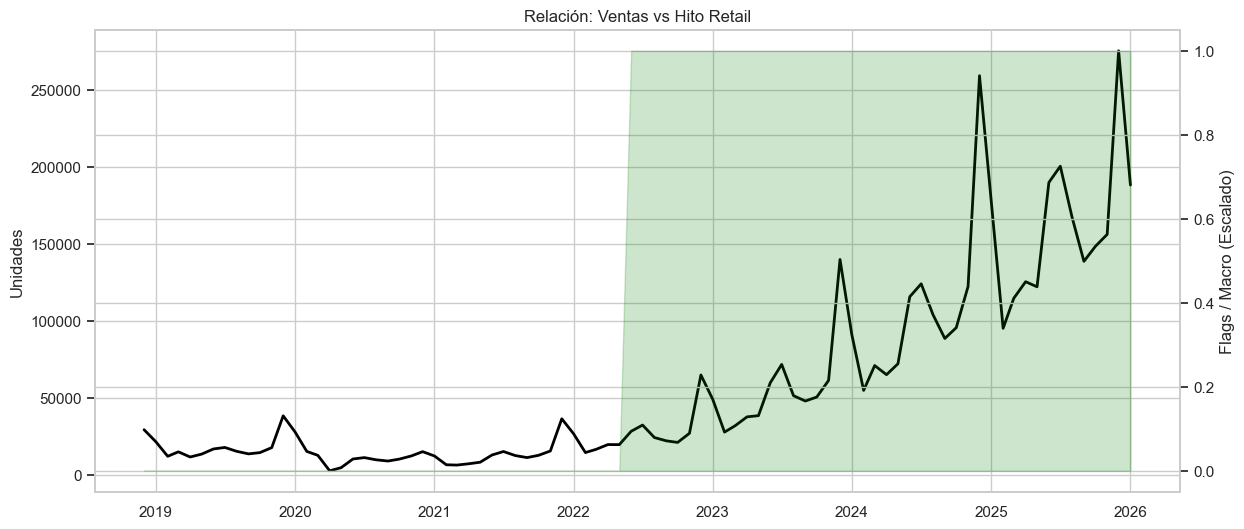

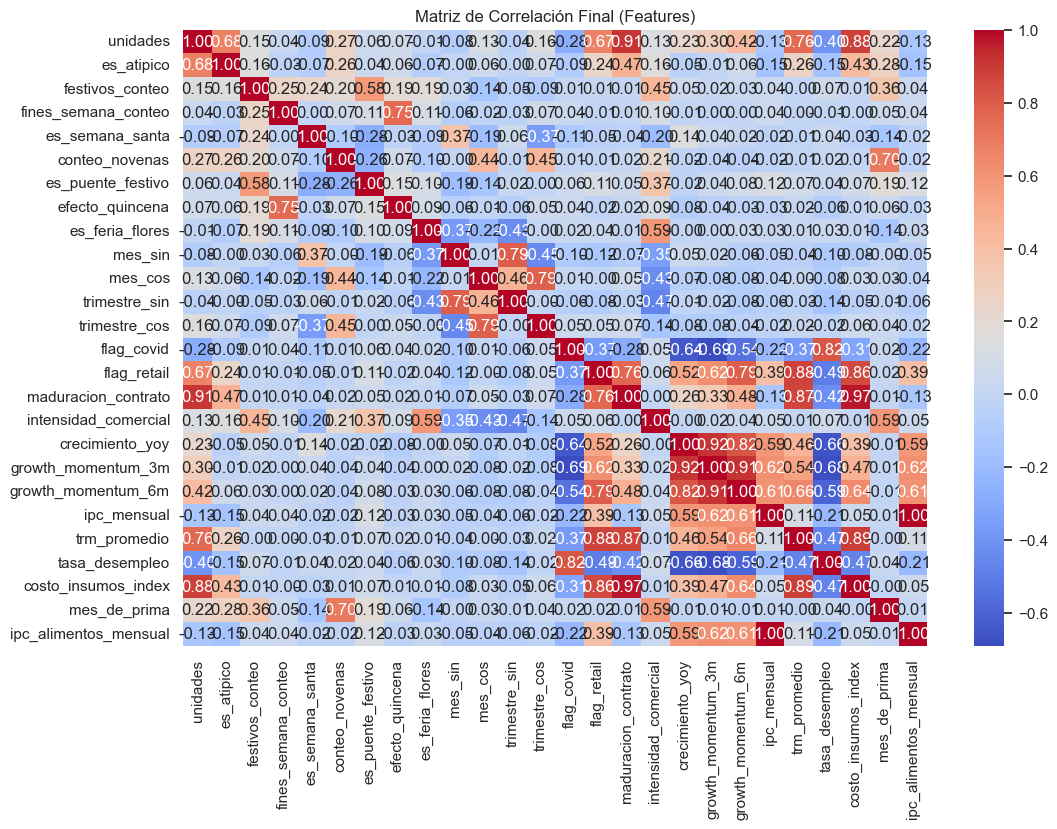

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df_final.index, df_final['unidades'], label='Ventas', color='black', linewidth=2)
ax1.set_ylabel('Unidades')

ax2 = ax1.twinx()
ax2.fill_between(df_final.index, 0, df_final['flag_retail'], alpha=0.2, color='green', label='Retail Expansion')
ax2.set_ylabel('Flags / Macro (Escalado)')

plt.title('Relación: Ventas vs Hito Retail')
plt.show()

# Correlación de Pearson Final
plt.figure(figsize=(12, 8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación Final (Features)')
plt.show()

### 6️⃣ Exportación Final
Guardamos en formato Parquet y generamos reporte.

In [10]:
output_dir = os.path.join("..", paths['processed_data'])
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, fe_conf['output']['filename'])
df_final.to_parquet(output_file)

print(f"🚀 Dataset final exportado a: {output_file}")

# Generar información detallada de columnas
column_info = {}
for col in df_final.columns:
    column_info[col] = {
        "type": str(df_final[col].dtype),
        "has_nulls": bool(df_final[col].isna().any()),
        "null_count": int(df_final[col].isna().sum())
    }

# Crear Reporte JSON enriquecido
report = {
    "phase": "04_Feature_Engineering",
    "timestamp": datetime.now().isoformat(),
    "final_rows": df_final.shape[0],
    "final_columns_count": len(df_final.columns),
    "column_details": column_info,
    "features_created": {
        "calendar": fe_conf['calendar']['features'],
        "structural": list(flags.keys()),
        "macro": macro_cols
    }
}

import json
report_path = os.path.join("..", paths['reports'], fe_conf['output']['report_name'])
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

print(f"📝 Reporte detallado de fase guardado en: {report_path}")

🚀 Dataset final exportado a: ..\data/04_processed/ventas_features.parquet
📝 Reporte detallado de fase guardado en: ..\outputs/reports/phase_04_summary_fe.json
